In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from scipy.stats import ttest_rel
import os

# ensure output directory for saved figures
os.makedirs('figures', exist_ok=True)

### Proportion of correctly and incorrectly predicted authors

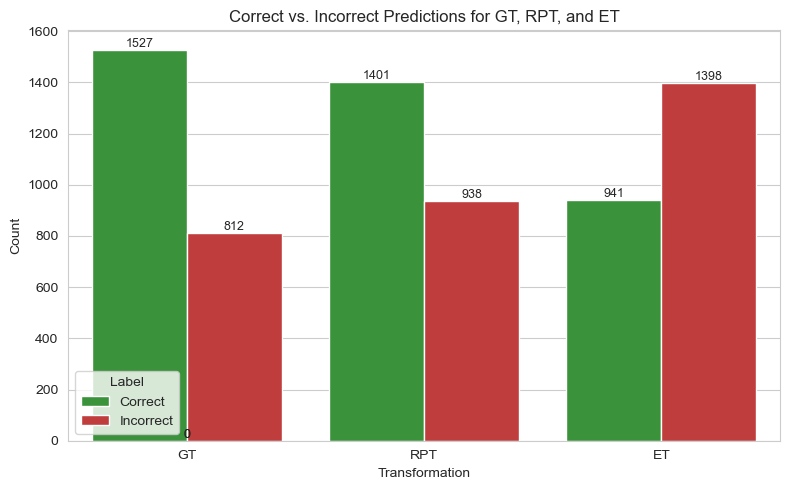

In [2]:
files = {
    "GT": "grayscale_results_df.csv",
    "RPT": "perspective_results_df.csv",
    "ET": "elastic_results_df.csv",
}

rows = []
for name, f in files.items():
    df = pd.read_csv(f)
    df['still_correct'] = df['still_correct'].astype(str).str.lower().map({'true': True, 'false': False})
    counts = df['still_correct'].value_counts().reindex([True, False], fill_value=0)
    rows.append({"Transformation": name, "Correct": int(counts[True]), "Incorrect": int(counts[False])})

df_counts = pd.DataFrame(rows)
df_melt = df_counts.melt(id_vars="Transformation", value_vars=["Correct", "Incorrect"],
                         var_name="Label", value_name="count")

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=df_melt, x="Transformation", y="count", hue="Label",
            palette=["tab:green", "tab:red"], ax=ax)
ax.set_ylabel("Count")
ax.set_title("Correct vs. Incorrect Predictions for GT, RPT, and ET")
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center", va="bottom", fontsize=9)
plt.tight_layout()
fig.savefig('combined_correct_incorrect.png', dpi=150)
plt.show()

## Model confidence for correct and incorrect predictions

### Grayscale

count     2339.000000
mean        -0.023745
median      -0.022828
std          0.017774
min         -0.105574
max          0.028031
Name: diff, dtype: float64
> positive/negative/zero: 198 2137 4
Pearson corr: 0.6636841857051906
Paired t-test: t=-64.609 p=0.000e+00


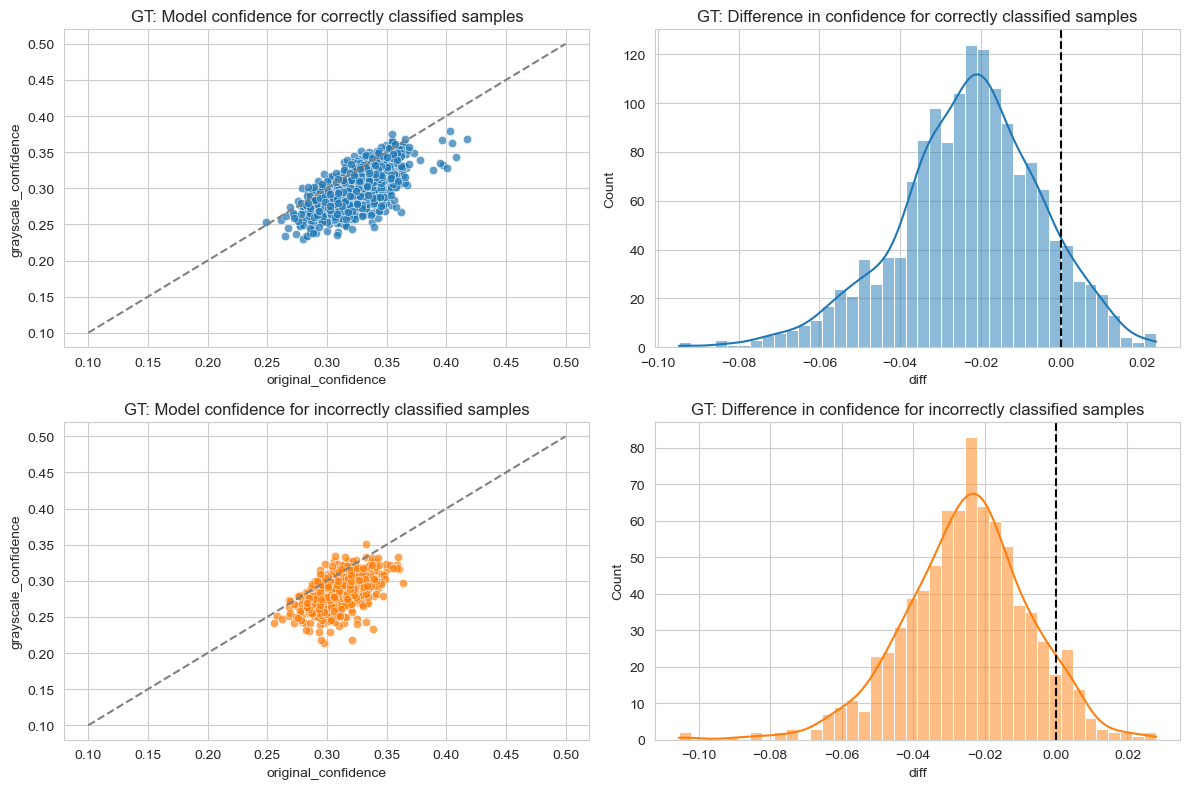

               count      mean       std    median
still_correct                                     
False            812 -0.025187  0.017694 -0.024076
True            1527 -0.022977  0.017775 -0.022142


In [3]:
df_grayscale = pd.read_csv('grayscale_results_df.csv')

df = df_grayscale.copy()
cols = ['original_confidence', 'grayscale_confidence']
df = df.dropna(subset=cols)
df['diff'] = df['grayscale_confidence'] - df['original_confidence']

# coerce still_correct to boolean
if 'still_correct' in df.columns:
    df['still_correct'] = df['still_correct'].astype(str).str.lower().map({'true': True, 'false': False})
else:
    df['still_correct'] = False

# split into correct / incorrect
df_correct = df[df['still_correct'] == True]
df_incorrect = df[df['still_correct'] == False]

# summary
print(df['diff'].agg(['count','mean','median','std','min','max']))
print("> positive/negative/zero:", (df['diff']>0).sum(), (df['diff']<0).sum(), (df['diff']==0).sum())
print("Pearson corr:", df[cols].corr().iloc[0,1])
tstat, pval = ttest_rel(df['grayscale_confidence'], df['original_confidence'])
print("Paired t-test: t=%.3f p=%.3e" % (tstat, pval))

# plots: 2x2 (correct / incorrect => scatter + hist)
fig, axs = plt.subplots(2,2,figsize=(12,8))

# correct: scatter + hist
sns.scatterplot(x='original_confidence', y='grayscale_confidence', data=df_correct, ax=axs[0,0], alpha=0.7)
axs[0,0].plot([0.1,0.5],[0.1,0.5], ls='--', color='gray')
axs[0,0].set_title('GT: Model confidence for correctly classified samples')
sns.histplot(df_correct['diff'], bins=40, kde=True, ax=axs[0,1])
axs[0,1].axvline(0, color='k', ls='--')
axs[0,1].set_title('GT: Difference in confidence for correctly classified samples')

# incorrect: scatter + hist
sns.scatterplot(x='original_confidence', y='grayscale_confidence', data=df_incorrect, ax=axs[1,0], alpha=0.7, color='C1')
axs[1,0].plot([0.1,0.5],[0.1,0.5], ls='--', color='gray')
axs[1,0].set_title('GT: Model confidence for incorrectly classified samples')
sns.histplot(df_incorrect['diff'], bins=40, kde=True, ax=axs[1,1], color='C1')
axs[1,1].axvline(0, color='k', ls='--')
axs[1,1].set_title('GT: Difference in confidence for incorrectly classified samples')

plt.tight_layout()
fig.savefig('figures/grayscale_confidence_scatter_hist_split.png', dpi=150)
plt.show()

# optional: per-group stats by still_correct
print(df.groupby('still_correct')['diff'].agg(['count','mean','std','median']))

### Random Perspective

count     2339.000000
mean        -0.019859
median      -0.018334
std          0.017881
min         -0.107265
max          0.040089
Name: diff, dtype: float64
> positive/negative/zero: 273 2066 0
Pearson corr: 0.5872545591298177
Paired t-test: t=-53.714 p=0.000e+00


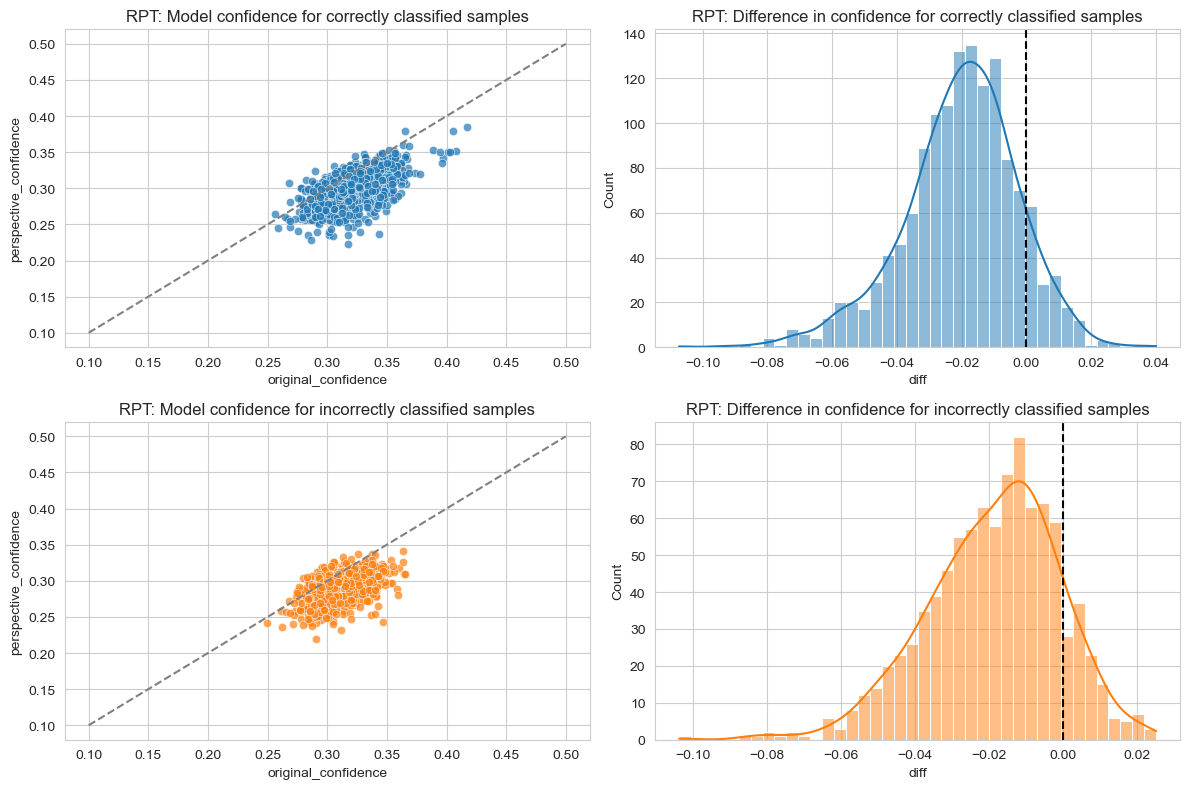

               count      mean       std    median
still_correct                                     
False            938 -0.018984  0.017896 -0.017103
True            1401 -0.020445  0.017854 -0.018997


In [4]:
df_random_perspective = pd.read_csv('perspective_results_df.csv')

df = df_random_perspective.copy()
cols = ['original_confidence', 'perspective_confidence']
df = df.dropna(subset=cols)
df['diff'] = df['perspective_confidence'] - df['original_confidence']

# coerce still_correct to boolean
if 'still_correct' in df.columns:
    df['still_correct'] = df['still_correct'].astype(str).str.lower().map({'true': True, 'false': False})
else:
    df['still_correct'] = False

df_correct = df[df['still_correct'] == True]
df_incorrect = df[df['still_correct'] == False]

# summary
print(df['diff'].agg(['count','mean','median','std','min','max']))
print("> positive/negative/zero:", (df['diff']>0).sum(), (df['diff']<0).sum(), (df['diff']==0).sum())
print("Pearson corr:", df[cols].corr().iloc[0,1])
tstat, pval = ttest_rel(df['perspective_confidence'], df['original_confidence'])
print("Paired t-test: t=%.3f p=%.3e" % (tstat, pval))

# plots: 2x2 (correct / incorrect)
fig, axs = plt.subplots(2,2,figsize=(12,8))

# correct
sns.scatterplot(x='original_confidence', y='perspective_confidence', data=df_correct, ax=axs[0,0], alpha=0.7)
axs[0,0].plot([0.1,0.5],[0.1,0.5], ls='--', color='gray')
axs[0,0].set_title('RPT: Model confidence for correctly classified samples')
sns.histplot(df_correct['diff'], bins=40, kde=True, ax=axs[0,1])
axs[0,1].axvline(0, color='k', ls='--')
axs[0,1].set_title('RPT: Difference in confidence for correctly classified samples')

# incorrect
sns.scatterplot(x='original_confidence', y='perspective_confidence', data=df_incorrect, ax=axs[1,0], alpha=0.7, color='C1')
axs[1,0].plot([0.1,0.5],[0.1,0.5], ls='--', color='gray')
axs[1,0].set_title('RPT: Model confidence for incorrectly classified samples')
sns.histplot(df_incorrect['diff'], bins=40, kde=True, ax=axs[1,1], color='C1')
axs[1,1].axvline(0, color='k', ls='--')
axs[1,1].set_title('RPT: Difference in confidence for incorrectly classified samples')

plt.tight_layout()
fig.savefig('figures/perspective_confidence_scatter_hist_split.png', dpi=150)
plt.show()

# optional: per-group stats by still_correct
print(df.groupby('still_correct')['diff'].agg(['count','mean','std','median']))
# ...existing code...

### Elastic Transform

count     2339.000000
mean        -0.010773
median      -0.009893
std          0.019604
min         -0.084951
max          0.059826
Name: diff, dtype: float64
> positive/negative/zero: 664 1675 0
Pearson corr: 0.5390310380566341
Paired t-test: t=-26.576 p=3.273e-136


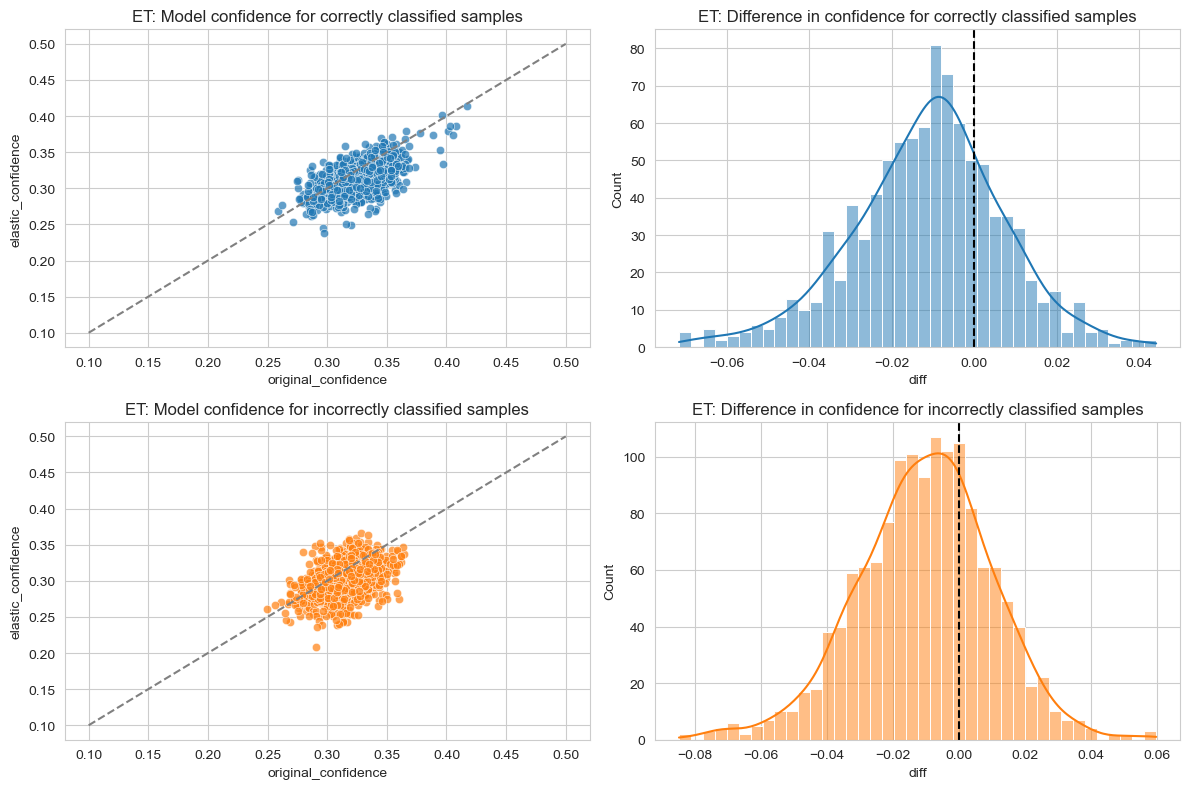

               count      mean       std    median
still_correct                                     
False           1398 -0.010445  0.020459 -0.009650
True             941 -0.011260  0.018261 -0.010054


In [5]:
df_elastic = pd.read_csv('elastic_results_df.csv')

df = df_elastic.copy()
cols = ['original_confidence', 'elastic_confidence']
df = df.dropna(subset=cols)
df['diff'] = df['elastic_confidence'] - df['original_confidence']

if 'still_correct' in df.columns:
    df['still_correct'] = df['still_correct'].astype(str).str.lower().map({'true': True, 'false': False})
else:
    df['still_correct'] = False

df_correct = df[df['still_correct'] == True]
df_incorrect = df[df['still_correct'] == False]

# summary
print(df['diff'].agg(['count','mean','median','std','min','max']))
print("> positive/negative/zero:", (df['diff']>0).sum(), (df['diff']<0).sum(), (df['diff']==0).sum())
print("Pearson corr:", df[cols].corr().iloc[0,1])
tstat, pval = ttest_rel(df['elastic_confidence'], df['original_confidence'])
print("Paired t-test: t=%.3f p=%.3e" % (tstat, pval))

# plots: 2x2 (correct / incorrect)
fig, axs = plt.subplots(2,2,figsize=(12,8))

# correct
sns.scatterplot(x='original_confidence', y='elastic_confidence', data=df_correct, ax=axs[0,0], alpha=0.7)
axs[0,0].plot([0.1,0.5],[0.1,0.5], ls='--', color='gray')
axs[0,0].set_title('ET: Model confidence for correctly classified samples')
sns.histplot(df_correct['diff'], bins=40, kde=True, ax=axs[0,1])
axs[0,1].axvline(0, color='k', ls='--')
axs[0,1].set_title('ET: Difference in confidence for correctly classified samples')

# incorrect
sns.scatterplot(x='original_confidence', y='elastic_confidence', data=df_incorrect, ax=axs[1,0], alpha=0.7, color='C1')
axs[1,0].plot([0.1,0.5],[0.1,0.5], ls='--', color='gray')
axs[1,0].set_title('ET: Model confidence for incorrectly classified samples')
sns.histplot(df_incorrect['diff'], bins=40, kde=True, ax=axs[1,1], color='C1')
axs[1,1].axvline(0, color='k', ls='--')
axs[1,1].set_title('ET: Difference in confidence for incorrectly classified samples')

plt.tight_layout()
fig.savefig('figures/elastic_confidence_scatter_hist_split.png', dpi=150)
plt.show()

# optional: per-group stats by still_correct
print(df.groupby('still_correct')['diff'].agg(['count','mean','std','median']))


In [6]:
# Combine still_correct from grayscale / perspective / elastic into one table and keep all columns
df_g = pd.read_csv('grayscale_results_df.csv')
df_p = pd.read_csv('perspective_results_df.csv')
df_e = pd.read_csv('elastic_results_df.csv')
for d in (df_g, df_p, df_e):
    d['still_correct'] = d['still_correct'].astype(str).str.lower().map({'true': True, 'false': False})

# determine possible merge keys (exclude known non-key cols)
exclude = {'still_correct','original_confidence','grayscale_confidence','perspective_confidence','elastic_confidence'}
common = list((set(df_g.columns) & set(df_p.columns) & set(df_e.columns)) - exclude)

def prefix_non_keys(df, prefix, keys):
    rename_map = {c: f'{prefix}{c}' for c in df.columns if c not in keys}
    return df.rename(columns=rename_map)

if common:
    keys = common
    g = prefix_non_keys(df_g, 'grayscale_', keys)
    p = prefix_non_keys(df_p, 'perspective_', keys)
    e = prefix_non_keys(df_e, 'elastic_', keys)
    merged = g.merge(p, on=keys, how='outer').merge(e, on=keys, how='outer')
else:
    # fall back to index-based merge (adds row_id) and keep all columns
    df_g_i = df_g.reset_index().rename(columns={'index':'row_id'})
    df_p_i = df_p.reset_index().rename(columns={'index':'row_id'})
    df_e_i = df_e.reset_index().rename(columns={'index':'row_id'})
    keys = ['row_id']
    g = prefix_non_keys(df_g_i, 'grayscale_', keys)
    p = prefix_non_keys(df_p_i, 'perspective_', keys)
    e = prefix_non_keys(df_e_i, 'elastic_', keys)
    merged = g.merge(p, on=keys, how='outer').merge(e, on=keys, how='outer')

merged.to_csv('combined_still_correct_full.csv', index=False)
print('Saved combined_still_correct_full.csv')
merged.head()

Saved combined_still_correct_full.csv


,image_file,title,true_author,original_prediction,grayscale_original_confidence,grayscale_grayscale_prediction,grayscale_grayscale_confidence,grayscale_still_correct,perspective_original_confidence,perspective_perspective_prediction,perspective_perspective_confidence,perspective_still_correct,elastic_original_confidence,elastic_elastic_prediction,elastic_elastic_confidence,elastic_still_correct
0,08687-11brioch.jpg,'La Brioche' (Cake),"CHARDIN, Jean-Baptiste-Siméon","CHARDIN, Jean-Baptiste-Siméon",0.332480,"CHARDIN, Jean-Baptiste-Siméon",0.312258,True,0.332480,"ARCIMBOLDO, Giuseppe",0.293992,False,0.332480,"FRAGONARD, Jean-Honoré",0.291565,False
1,43774-09loveso.jpg,'La gamme d'amour' (The Love Song),"WATTEAU, Jean-Antoine","WATTEAU, Jean-Antoine",0.319069,"FRAGONARD, Jean-Honoré",0.285674,False,0.319069,"FRAGONARD, Jean-Honoré",0.303996,False,0.319069,"FRAGONARD, Jean-Honoré",0.346510,False
2,35636-04sketch.jpg,'Modello' for the Assumption of Mary,"RUBENS, Peter Paul","RUBENS, Peter Paul",0.298960,TINTORETTO,0.292291,False,0.298960,"VERONESE, Paolo",0.306904,False,0.298960,"FRAGONARD, Jean-Honoré",0.335517,False
3,31082-1adam01.jpg,1. Death of Adam,PIERO DELLA FRANCESCA,PIERO DELLA FRANCESCA,0.333348,PIERO DELLA FRANCESCA,0.264846,True,0.333348,PIERO DELLA FRANCESCA,0.311919,True,0.333348,"LORENZETTI, Pietro",0.317963,False
4,31083-1adam02.jpg,1. Death of Adam,PIERO DELLA FRANCESCA,PIERO DELLA FRANCESCA,0.337872,PIERO DELLA FRANCESCA,0.266162,True,0.337872,PIERO DELLA FRANCESCA,0.310760,True,0.337872,"LORENZETTI, Pietro",0.320992,False


## Statistics for the dataset 

In [7]:
# Summary stats: remain correctly predicted after 1,2,3 transforms
import pandas as pd

def build_merged_if_needed():
    try:
        return pd.read_csv('combined_still_correct_full.csv')
    except Exception:
        df_g = pd.read_csv('grayscale_results_df.csv')
        df_p = pd.read_csv('perspective_results_df.csv')
        df_e = pd.read_csv('elastic_results_df.csv')
        for d in (df_g, df_p, df_e):
            d['still_correct'] = d['still_correct'].astype(str).str.lower().map({'true': True, 'false': False})
        exclude = {'still_correct','original_confidence','grayscale_confidence','perspective_confidence','elastic_confidence'}
        common = list((set(df_g.columns) & set(df_p.columns) & set(df_e.columns)) - exclude)
        def prefix_non_keys(df, prefix, keys):
            rename_map = {c: f'{prefix}{c}' for c in df.columns if c not in keys}
            return df.rename(columns=rename_map)
        if common:
            keys = common
            g = prefix_non_keys(df_g, 'grayscale_', keys)
            p = prefix_non_keys(df_p, 'perspective_', keys)
            e = prefix_non_keys(df_e, 'elastic_', keys)
            merged = g.merge(p, on=keys, how='outer').merge(e, on=keys, how='outer')
        else:
            df_g_i = df_g.reset_index().rename(columns={'index':'row_id'})
            df_p_i = df_p.reset_index().rename(columns={'index':'row_id'})
            df_e_i = df_e.reset_index().rename(columns={'index':'row_id'})
            keys = ['row_id']
            g = prefix_non_keys(df_g_i, 'grayscale_', keys)
            p = prefix_non_keys(df_p_i, 'perspective_', keys)
            e = prefix_non_keys(df_e_i, 'elastic_', keys)
            merged = g.merge(p, on=keys, how='outer').merge(e, on=keys, how='outer')
        return merged

merged = build_merged_if_needed()

# detect still-correct columns (common patterns)
still_cols = [c for c in merged.columns if ('still' in c.lower() and merged[c].dtype != object) or c.lower().endswith('_still')]
if not still_cols:
    # try explicit names used earlier
    for name in ('grayscale_still','perspective_still','elastic_still'):
        if name in merged.columns:
            still_cols.append(name)

# coerce to boolean (treat missing as False)
for c in still_cols:
    merged[c] = merged[c].astype('boolean').fillna(False)

# number of transforms that remain correct per row
merged['n_correct_transforms'] = merged[still_cols].sum(axis=1).astype(int)

# exact counts for 0..3
exact_counts = merged['n_correct_transforms'].value_counts().sort_index().reindex([0,1,2,3], fill_value=0).rename('count').to_frame()
exact_counts['pct_total'] = exact_counts['count'] / len(merged) * 100

# at-least thresholds
atleast = {
    '>=1': int((merged['n_correct_transforms'] >= 1).sum()),
    '>=2': int((merged['n_correct_transforms'] >= 2).sum()),
    '==3': int((merged['n_correct_transforms'] == 3).sum()),
}
atleast_df = pd.DataFrame.from_dict(atleast, orient='index', columns=['count'])
atleast_df['pct_total'] = atleast_df['count'] / len(merged) * 100

# also show proportions among rows that were originally correct if column exists
orig_col_candidates = [c for c in merged.columns if 'original' in c.lower() and 'correct' in c.lower()]
orig_stats = None
if orig_col_candidates:
    oc = orig_col_candidates[0]
    merged[oc] = merged[oc].astype('boolean').fillna(False)
    base = merged[merged[oc]==True]
    if len(base):
        orig_exact = base['n_correct_transforms'].value_counts().sort_index().reindex([0,1,2,3], fill_value=0).rename('count').to_frame()
        orig_exact['pct_of_original_correct'] = orig_exact['count'] / len(base) * 100
        orig_stats = orig_exact

print('Exact counts (0..3):')
print(exact_counts)
print('\nAt-least thresholds:')
print(atleast_df)
if orig_stats is not None:
    print('\nAmong originally-correct rows:')
    print(orig_stats)

# return small preview
merged[['n_correct_transforms'] + still_cols].head()

Exact counts (0..3):
                      count  pct_total
n_correct_transforms                  
0                       358  15.305686
1                       640  27.362121
2                       794  33.946131
3                       547  23.386062

At-least thresholds:
     count  pct_total
>=1   1981  84.694314
>=2   1341  57.332193
==3    547  23.386062


,n_correct_transforms,grayscale_still_correct,perspective_still_correct,elastic_still_correct
0,1,True,False,False
1,0,False,False,False
2,0,False,False,False
3,2,True,True,False
4,2,True,True,False


In [8]:
# Compute statistics for all 8 correctness combinations (Grayscale, Perspective, Elastic)
import pandas as pd

# ensure merged exists (created earlier in notebook) or load fallback
try:
    merged  # noqa
except NameError:
    merged = pd.read_csv('combined_still_correct_full.csv')

# helper to find a 'still' column for each transform
def find_still_col(df, prefix):
    pref = prefix.lower()
    # common patterns
    for c in df.columns:
        lc = c.lower()
        if pref in lc and 'still' in lc:
            return c
    # fallback: column exactly named 'still_correct' (prefixed versions may exist)
    if 'still_correct' in df.columns:
        return 'still_correct' if pref == 'grayscale' else None
    return None

g_col = find_still_col(merged, 'grayscale')
p_col = find_still_col(merged, 'perspective')
e_col = find_still_col(merged, 'elastic')

# coerce found columns to boolean, treat missing as False
for col in (g_col, p_col, e_col):
    if col and col in merged.columns:
        merged[col] = merged[col].astype(str).str.lower().map({'true': True, 'false': False}).fillna(False)

merged['g_correct'] = merged[g_col] if (g_col in merged.columns) else False
merged['p_correct'] = merged[p_col] if (p_col in merged.columns) else False
merged['e_correct'] = merged[e_col] if (e_col in merged.columns) else False

# bitmask string 'g p e' -> '010' etc (order: grayscale, perspective, elastic)
merged['comb_bits'] = merged[['g_correct','p_correct','e_correct']].apply(
    lambda r: ''.join(['1' if bool(x) else '0' for x in r]), axis=1
)

all_bits = ['000','001','010','011','100','101','110','111']
counts = merged['comb_bits'].value_counts().reindex(all_bits, fill_value=0)

def pretty_label(bits):
    m = {'1':'Y','0':'N'}
    return f"G:{m[bits[0]]} P:{m[bits[1]]} E:{m[bits[2]]} ({bits})"

comb_df = (
    pd.DataFrame({'bits': counts.index, 'count': counts.values})
    .assign(pct_total=lambda d: d['count'] / len(merged) * 100)
    .assign(label=lambda d: d['bits'].map(pretty_label))
    [['bits','label','count','pct_total']]
)

comb_df.to_csv('combination_stats.csv', index=False)
pd.options.display.float_format = '{:.2f}'.format
print('\nCounts for 8 combinations (Grayscale, Perspective, Elastic):')
print(comb_df.to_string(index=False))


Counts for 8 combinations (Grayscale, Perspective, Elastic):
bits             label  count  pct_total
 000 G:N P:N E:N (000)    358      15.31
 001 G:N P:N E:Y (001)     78       3.33
 010 G:N P:Y E:N (010)    227       9.71
 011 G:N P:Y E:Y (011)    149       6.37
 100 G:Y P:N E:N (100)    335      14.32
 101 G:Y P:N E:Y (101)    167       7.14
 110 G:Y P:Y E:N (110)    478      20.44
 111 G:Y P:Y E:Y (111)    547      23.39
